This notebook tests out this fix for estimating treatment effect in regularised linear models:

Hahn, P.R., Carvalho, C.M., Puelz, D., He, J., 2018. Regularization and Confounding in Linear Regression for Treatment Effect Estimation. Bayesian Anal. 13. https://doi.org/10.1214/16-BA1044


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error

from twostageridge import TwoStageRidge, ridge_weights

np.random.seed(666)

%matplotlib inline

# Generate the data

In [2]:
N = 1000
D_rand = 100


# Confounders - X
mu_x = np.zeros(4)
cov_x = np.array([
    [ 1.0,  0.5,  0.0,  0.3],
    [ 0.5,  1.0, -0.2,  0.0],
    [ 0.0, -0.2,  1.0, -0.7],
    [ 0.3,  0.0, -0.7,  1.0]
])


# Treatment - Z
gamma = np.array([2., 1., -0.7, -0.5])
sig_eps = 0.1


# Target - Y
alpha = 1.6
beta = np.array([1., -2., 1.5, 0.6])
sig_nu = 0.9

# Generation function
def generate_data():
    X = np.random.multivariate_normal(mean=mu_x, cov=cov_x, size=N)
    
    Z = X @ gamma + sig_eps * np.random.randn(N)
    
    Y = alpha * Z + X @ beta + sig_nu * np.random.randn(N)
    
    Xrand = np.random.randn(N, D_rand)
    W = np.hstack((Z[:, np.newaxis], X, Xrand))
    
    return W, Y

W, Y = generate_data()


# Ridge regression test

Regularisation on alpha and beta "out of the box"

$$\mathcal{L}_Y = \frac{1}{N} \sum^N_{i=1} \|Y_i - (\alpha Z_i + X_i \beta) \|^2_2 + \lambda \alpha^2 + \lambda \|\beta\|_2^2$$

And "confounded"

$$\mathcal{L}_Y = \frac{1}{N} \sum^N_{i=1} \|Y_i - (\alpha Z_i + X_i \beta) \|^2_2 + \lambda \|\beta\|_2^2$$

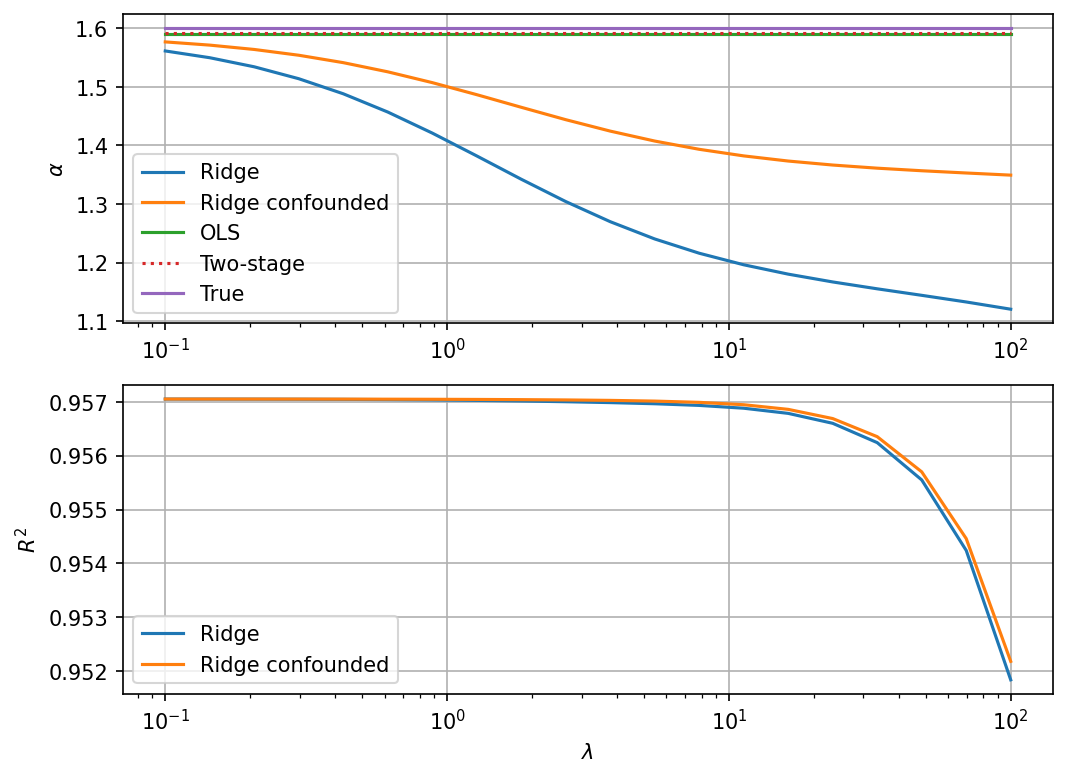

In [3]:
ols = LinearRegression().fit(W, Y)
alpha_ols =  ols.coef_[0]

ts = TwoStageRidge(treatment_index=0, regulariser1=1., regulariser2=1.).fit(W, Y)
alpha_ts = ts.alpha_

regularisers = np.logspace(-1, 2, 20)
alpha_ridge = np.zeros_like(regularisers)
alpha_conf = np.zeros_like(regularisers)
scores_ridge = np.zeros_like(regularisers)
scores_conf = np.zeros_like(regularisers)


for i, regulariser in enumerate(regularisers):
    reg = Ridge(alpha=regulariser).fit(W, Y)    
    alpha_ridge[i] = reg.coef_[0]
    scores_ridge[i] = r2_score(Y, reg.predict(W))
    
    Wint = np.hstack((W, np.ones((N, 1))))
    reg = np.ones(Wint.shape[1]) * regulariser
    reg[0] = 0.
    reg_conf_weights = ridge_weights(Wint, Y, gamma=reg)
    alpha_conf[i] = reg_conf_weights[0]
    scores_conf[i] = r2_score(Y, Wint @ reg_conf_weights)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), dpi=150)
ax1.semilogx(regularisers, alpha_ridge, label="Ridge")
ax1.semilogx(regularisers, alpha_conf, label="Ridge confounded")
ax1.semilogx([regularisers[0], regularisers[-1]], [alpha_ols, alpha_ols], label="OLS")
ax1.semilogx([regularisers[0], regularisers[-1]], [alpha_ts, alpha_ts], ':', label="Two-stage")
ax1.semilogx([regularisers[0], regularisers[-1]], [alpha, alpha], label="True")
ax1.set_ylabel("$\\alpha$")
ax1.grid()
ax1.legend()
ax2.semilogx(regularisers, scores_ridge, label="Ridge")
ax2.semilogx(regularisers, scores_conf, label="Ridge confounded")
ax2.grid()
ax2.set_ylabel("$R^2$")
ax2.set_xlabel("$\\lambda$")
ax2.legend()
plt.show()

# Two-stage test

## Vary $\lambda_d$

\begin{align}
\mathcal{L}_Z &= \frac{1}{N} \sum^N_{i=1} \|Z_i - X_i \beta_c \|^2_2 + \lambda_c \|\beta_c\|_2^2 \\
\mathcal{L}_Y &= \frac{1}{N} \sum^N_{i=1} \|Y_i - [\alpha(Z_i - X_i \beta_c) + X_i \beta_d] \|^2_2 + \lambda \|\beta_d\|_2^2
\end{align}

<img src="two_stage_dag.svg" width="50%">

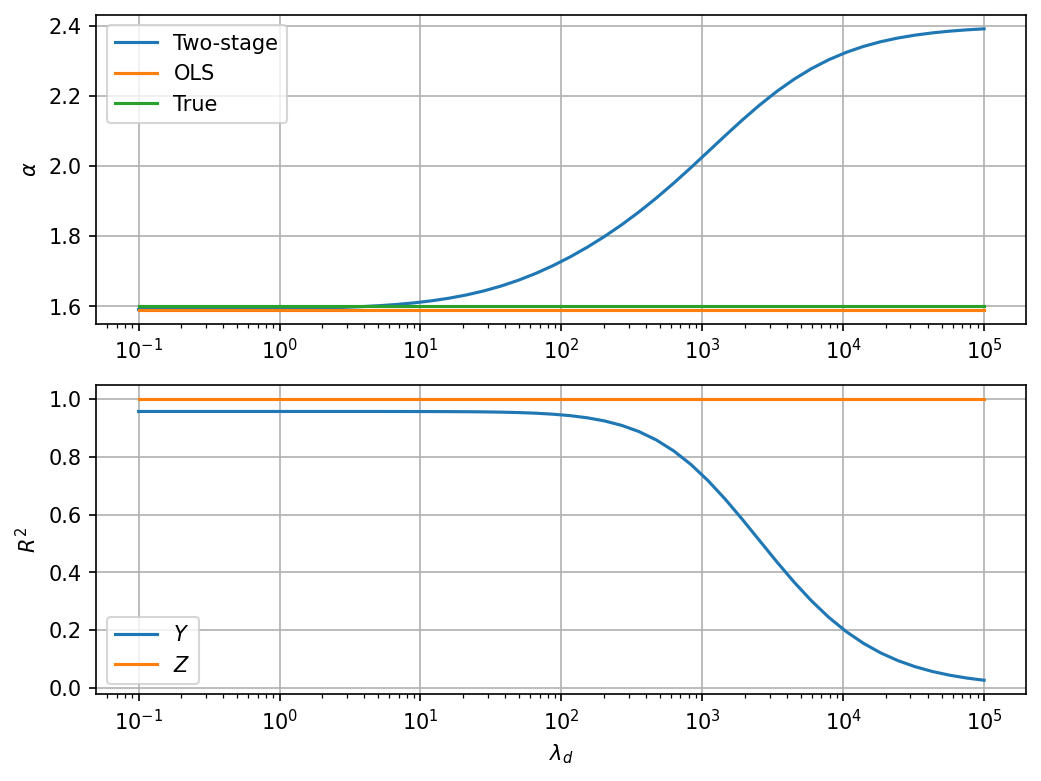

In [4]:
regularisers = np.logspace(-1, 5, 50)
alpha_ts_d = np.zeros_like(regularisers)
y_scores = np.zeros_like(regularisers)
z_scores = np.zeros_like(regularisers)


for i, regulariser in enumerate(regularisers):
    ts_d = TwoStageRidge(treatment_index=0, regulariser1=1., regulariser2=regulariser).fit(W, Y)
    alpha_ts_d[i] = ts_d.alpha_
    y_scores[i] = r2_score(Y, ts_d.predict(W))
    z_scores[i] = ts_d.score_stage1(W)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), dpi=150)
ax1.semilogx(regularisers, alpha_ts_d, label="Two-stage")
ax1.semilogx([regularisers[0], regularisers[-1]], [alpha_ols, alpha_ols], label="OLS")
ax1.semilogx([regularisers[0], regularisers[-1]], [alpha, alpha], label="True")
ax1.set_ylabel("$\\alpha$")
ax1.grid()
ax1.legend()
ax2.semilogx(regularisers, y_scores, label="$Y$")
ax2.semilogx(regularisers, z_scores, label="$Z$")
ax2.grid()
ax2.legend()
ax2.set_ylabel("$R^2$")
ax2.set_xlabel("$\\lambda_d$")
plt.show()

## Vary $\lambda_c$

\begin{align}
\mathcal{L}_Z &= \frac{1}{N} \sum^N_{i=1} \|Z_i - X_i \beta_c \|^2_2 + \lambda_c \|\beta_c\|_2^2 \\
\mathcal{L}_Y &= \frac{1}{N} \sum^N_{i=1} \|Y_i - [\alpha(Z_i - X_i \beta_c) + X_i \beta_d] \|^2_2 + \lambda \|\beta_d\|_2^2
\end{align}

<img src="two_stage_dag.svg" width="50%">

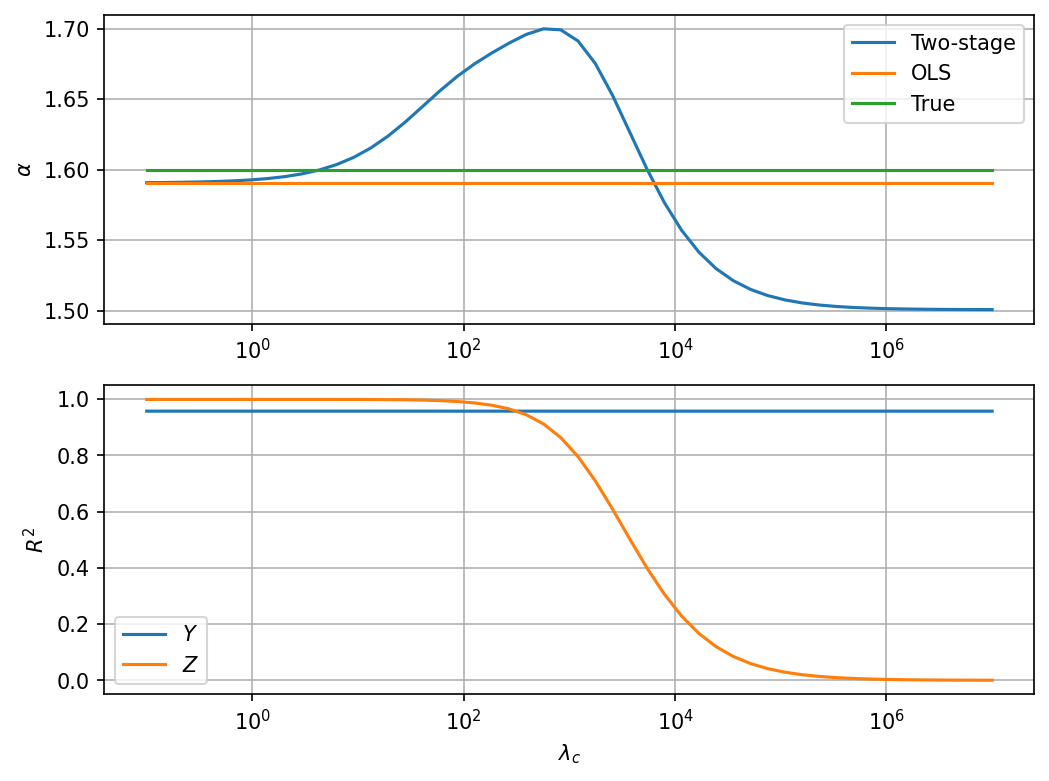

In [5]:
regularisers = np.logspace(-1, 7, 50)
alpha_ts_c = np.zeros_like(regularisers)
y_scores = np.zeros_like(regularisers)
z_scores = np.zeros_like(regularisers)


for i, regulariser in enumerate(regularisers):
    ts_c = TwoStageRidge(treatment_index=0, regulariser1=regulariser, regulariser2=1.).fit(W, Y)
    alpha_ts_c[i] = ts_c.alpha_
    y_scores[i] = r2_score(Y, ts_c.predict(W))
    z_scores[i] = ts_c.score_stage1(W)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), dpi=150)
ax1.semilogx(regularisers, alpha_ts_c, label="Two-stage")
ax1.semilogx([regularisers[0], regularisers[-1]], [alpha_ols, alpha_ols], label="OLS")
ax1.semilogx([regularisers[0], regularisers[-1]], [alpha, alpha], label="True")
ax1.set_ylabel("$\\alpha$")
ax1.grid()
ax1.legend()
ax2.semilogx(regularisers, y_scores, label="$Y$")
ax2.semilogx(regularisers, z_scores, label="$Z$")
ax2.grid()
ax2.legend()
ax2.set_ylabel("$R^2$")
ax2.set_xlabel("$\\lambda_c$")
plt.show()

# Extensions

Original formulation:

\begin{align}
    Z &= X \beta_c + \epsilon, \\
    Y &= \alpha(Z - X \beta_c) + X \beta_d + \nu.
\end{align}

This can be easily made nonlinear:

\begin{align}
    Z &= \phi_\theta(X) \beta_c + \epsilon, \\
    Y &= \alpha\{Z - \phi_\theta(X) \beta_c\} + \phi_\theta(X) \beta_d + \nu.
\end{align}

For some nonlinear basis $\phi_\theta(\cdot)$. Note the shared parameter, $\theta$.

Q: Could we learn a different basis for each stage and this still be valid??

Probably is double machine learning:
\begin{align}
    Z &= g(X_1, X_2) + \epsilon, \\
    Y &= \theta(X_1) \cdot \{Z - g(X_1, X_2)\} + f(X_1, X_2) + \nu.
\end{align}